<a href="https://colab.research.google.com/github/neoyang0620/Awesome-CV/blob/master/Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from skimage.transform import resize
from scipy import ndimage
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_DIR = '../content/drive/My Drive/Project3/comp-551-w2019-project-3-modified-mnist'

def get_train_data():
  train_images = pd.read_pickle(os.path.join(DATA_DIR, 'train_images.pkl'))
  train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
  return train_images, train_labels

def get_test_data():
  return pd.read_pickle(os.path.join(DATA_DIR, 'test_images.pkl'))
def showImage(img_idx):
  plt.title('Label: {}'.format(train_labels.iloc[img_idx]['Category']))
  plt.imshow(train_images[img_idx])
def preprocess(data):
  data = np.where(data>250, 1, 0)
  return data


In [17]:
a = pd.read_pickle(os.path.join(DATA_DIR, 'train_images.pkl'))
a.shape

(40000, 64, 64)

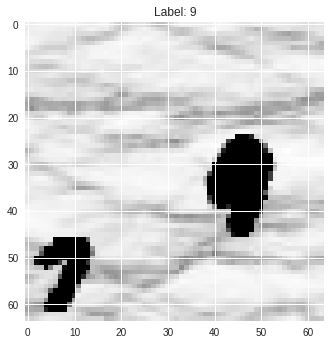

In [9]:
train_images, train_labels = get_train_data()
showImage(img_idx = 0)



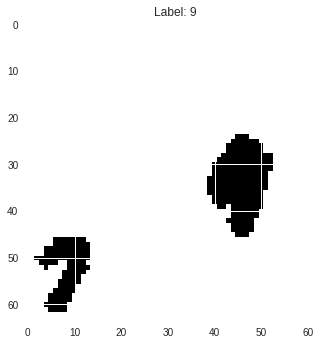

In [10]:
train_images = preprocess(train_images)
showImage(img_idx = 0)

Find the largest digit

In [0]:
X_train_extracted = []
for im in train_images:
#   im = train_image[17]

  # find out all the connect components
  mask = im > im.mean()
  label_im, nb_labels = ndimage.label(mask)

  # remove some small pieces and background
  sizes = ndimage.sum(mask, label_im, range(nb_labels + 1)) # give background an label
  mask_size = sizes < 70
  remove_pixel = mask_size[label_im]
  label_im[remove_pixel] = 0  

  # clean up label_im and compute the new label
  labels = np.unique(label_im)
  label_im = np.searchsorted(labels, label_im)

  # Slice out the largest digit
  best_slice_x, best_slice_y = 0,0
  max_area = 0
  for i in range(len(labels)-1): # ignore the background
      slice_x, slice_y = ndimage.find_objects(label_im==i+1)[0]
      area = max((slice_x.stop - slice_x.start),(slice_y.stop - slice_y.start))
  #     area = (slice_x.stop - slice_x.start)*(slice_y.stop - slice_y.start)
#       print("Area",end = ': ')
#       print(area)

      if(area > max_area):
          max_area = area
          best_slice_x = slice_x
          best_slice_y = slice_y
  # largest_digit = im[best_slice_x, best_slice_y]
  largest_digit = im[best_slice_x.start:best_slice_x.start+max_area, best_slice_y.start:best_slice_y.start+max_area]
  X_train_extracted.append(largest_digit)


40000


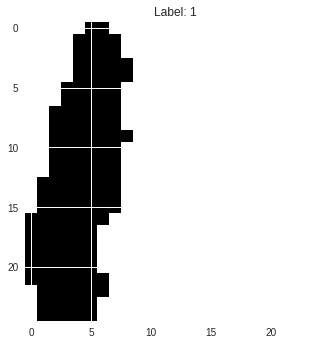

In [12]:
print(len(X_train_extracted))
plt.title('Label: {}'.format(train_labels.iloc[8]['Category']))
plt.imshow(X_train_extracted[8])

In [21]:
resized_arr = []
for image in X_train_extracted:
    resized_image = resize(image, (30,30))
    resized_arr.append(resized_image)

#Binarize the images
# resized_arr_bin = np.where(np.array(resized_arr)>125, 1, 0)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


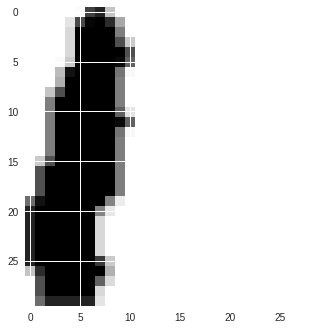

In [22]:
plt.imshow(resized_arr[8])

Setup the dataset

In [0]:
import torch.utils.data as data

from PIL import Image
import os
import os.path

class ImageFilelist(data.Dataset):
	def __init__(self, root, flist, transform=None, target_transform=None,
			flist_reader=default_flist_reader, loader=default_loader):
		self.root   = root
		self.imlist = flist_reader(flist)		
		self.transform = transform
		self.target_transform = target_transform
		self.loader = loader

	def __getitem__(self, index):
		impath, target = self.imlist[index]
		img = self.loader(os.path.join(self.root,impath))
		if self.transform is not None:
			img = self.transform(img)
		if self.target_transform is not None:
			target = self.target_transform(target)
		
		return img, target

	def __len__(self):
		return len(self.imlist)